In [1]:
# ------------------------------------------------------------
# Linear model for Fahrzeuge_OEM1_Typ11_Fehleranalyse
# Target: Fehlerhaft_Fahrleistung (mileage at failure)
# Features: days (calendar age), fuel (fuel-related metric), engine (categorical)
# Notes:
# - Comments and variable names are in English.
# - Code is ready to run but will NOT be executed here.
# ------------------------------------------------------------

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression  # you can switch to Ridge/Lasso if needed
from sklearn.metrics import r2_score, mean_squared_error

# ----------------------------
# 1) Load and basic cleaning
# ----------------------------
csv_path = Path("source/Fahrzeug/Fahrzeuge_OEM1_Typ11_Fehleranalyse.csv")

# Read CSV; handle commas and quotes as in your sample
vehicle_df = pd.read_csv(csv_path)

# Drop obvious unnamed index-like columns if present
vehicle_df = vehicle_df.loc[:, ~vehicle_df.columns.str.match(r"^Unnamed|^$|^\"\"$")]

# Ensure expected columns exist
required_cols = [
    "Fehlerhaft_Fahrleistung",  # target
    "days",                     # numeric
    "fuel",                     # numeric
    "engine"                    # categorical (e.g., "small", "medium", "large")
]
missing_cols = [c for c in required_cols if c not in vehicle_df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

# Coerce numeric types safely
for num_col in ["Fehlerhaft_Fahrleistung", "days", "fuel"]:
    vehicle_df[num_col] = pd.to_numeric(vehicle_df[num_col], errors="coerce")

# Drop rows with missing target or features needed for the model
vehicle_df = vehicle_df.dropna(subset=["Fehlerhaft_Fahrleistung", "days", "fuel", "engine"]).copy()

# Optional: filter to OEM1 / Typ11 scope if dataset contains other OEMs or types.
# (Uncomment if needed and adjust column names accordingly.)
# vehicle_df = vehicle_df[(vehicle_df["Herstellernummer"] == 1) & (vehicle_df["Werksnummer"] == 11)]

# -------------------------------------
# 2) Define features (X) and target (y)
# -------------------------------------
target_column_name = "Fehlerhaft_Fahrleistung"
feature_column_names = ["days", "fuel", "engine"]

X_features = vehicle_df[feature_column_names].copy()
y_target = vehicle_df[target_column_name].copy()

# -------------------------------------
# 3) Preprocess: one-hot encode 'engine'
# -------------------------------------
categorical_features = ["engine"]
numeric_features = ["days", "fuel"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat_engine", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
        ("num_passthrough", "passthrough", numeric_features),
    ],
    remainder="drop"
)

# -------------------------------------
# 4) Model pipeline
# -------------------------------------
linear_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", LinearRegression())
        # To try regularization, replace with:
        # ("regressor", Ridge(alpha=1.0, random_state=42))
        # or
        # ("regressor", Lasso(alpha=0.001, random_state=42))
    ]
)

# -------------------------------------
# 5) Train / test split and training
# -------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_target, test_size=0.2, random_state=42
)

linear_pipeline.fit(X_train, y_train)

# -------------------------------------
# 6) Evaluation
# -------------------------------------
y_pred = linear_pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))

print(f"Model R² score: {r2:.4f}")
print(f"Root Mean Squared Error: {rmse:.2f} km")

# -------------------------------------
# 7) Coefficients and interpretability
# -------------------------------------
# Get post-encoding feature names
# Sklearn >=1.0: get_feature_names_out is available on ColumnTransformer
encoded_feature_names = linear_pipeline.named_steps["preprocess"].get_feature_names_out()

# Extract coefficients and intercept from the linear model
coefficients = linear_pipeline.named_steps["regressor"].coef_
intercept = linear_pipeline.named_steps["regressor"].intercept_

coef_table = pd.DataFrame(
    {"Feature": encoded_feature_names, "Coefficient": coefficients}
)

# Make feature names more readable
# Example: "cat_engine__engine_small" -> "engine_small"
coef_table["Feature"] = (
    coef_table["Feature"]
    .str.replace(r"^cat_engine__", "", regex=True)
    .str.replace(r"^num_passthrough__", "", regex=True)
)

print("\nModel Coefficients:")
print(coef_table.sort_values(by="Feature").reset_index(drop=True))
print(f"\nIntercept: {intercept:.4f}")

# -------------------------------------
# 8) (Optional) Save artifacts
# -------------------------------------
# from joblib import dump
# dump(linear_pipeline, "oem1_typ11_linear_model.joblib")
# coef_table.to_csv("oem1_typ11_linear_model_coefficients.csv", index=False)

# -------------------------------------
# 9) (Optional) Simple what-if function
# -------------------------------------
def predict_mileage(days_value: float, fuel_value: float, engine_category: str) -> float:
    """
    Make a single prediction given raw feature values.
    engine_category should match categories seen in the data, e.g. 'small', 'medium', 'large'.
    """
    sample = pd.DataFrame(
        [{"days": days_value, "fuel": fuel_value, "engine": engine_category}],
        columns=["days", "fuel", "engine"]
    )
    return float(linear_pipeline.predict(sample)[0])

# Example (commented out):
# predicted = predict_mileage(days_value=1000, fuel_value=800, engine_category="small")
# print(f"Predicted mileage at failure: {predicted:.2f} km")


Model R² score: 0.4900
Root Mean Squared Error: 11114.10 km

Model Coefficients:
         Feature   Coefficient
0           days     -0.078592
1  engine_medium   7705.409026
2   engine_small  10953.705088
3           fuel   5213.581812

Intercept: 9899.6439


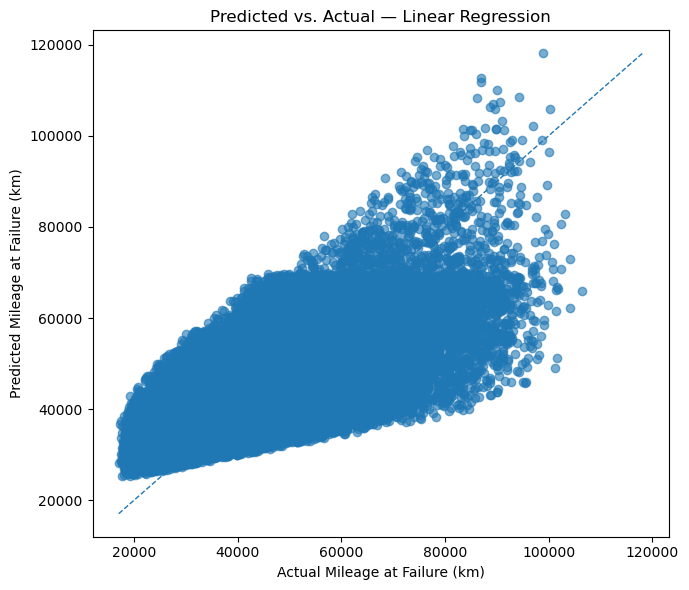

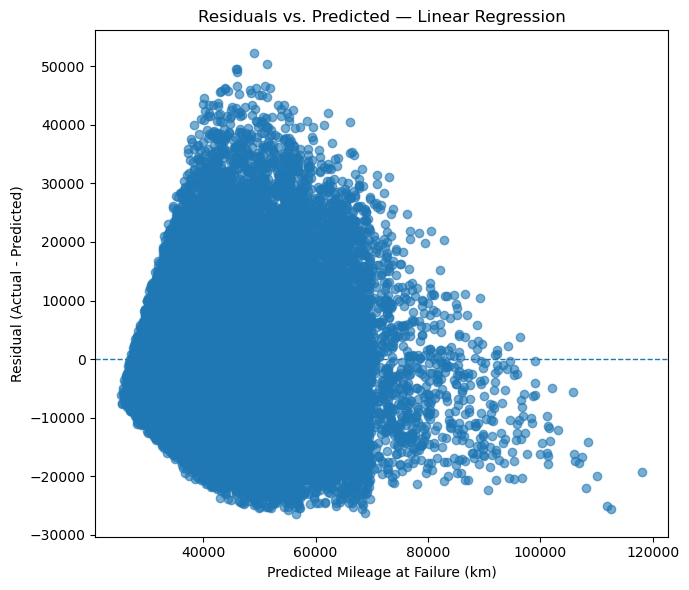

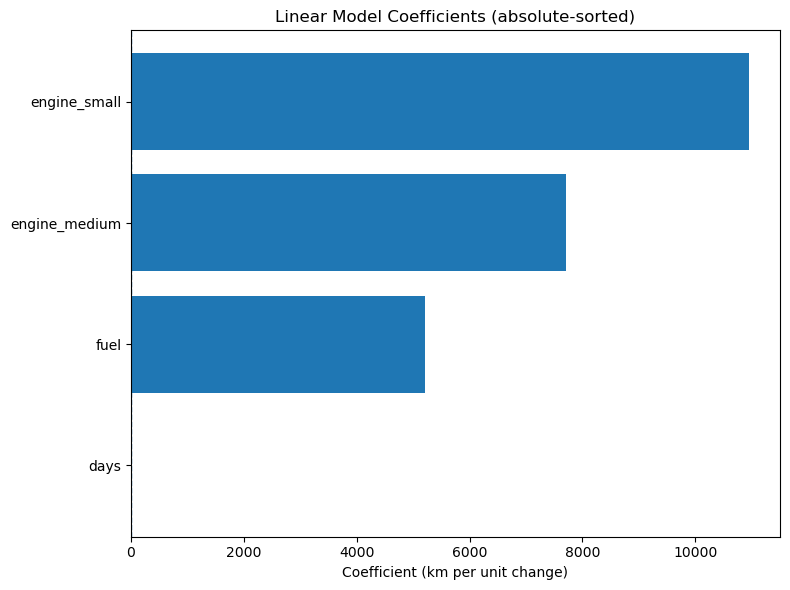

In [2]:
# ============================================================
# Part 1 — Visualization (run after the base linear model code)
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- 1) Predicted vs Actual scatter plot ---
plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
min_val = min(np.min(y_test), np.min(y_pred))
max_val = max(np.max(y_test), np.max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", linewidth=1)  # 45-degree line
plt.xlabel("Actual Mileage at Failure (km)")
plt.ylabel("Predicted Mileage at Failure (km)")
plt.title("Predicted vs. Actual — Linear Regression")
plt.tight_layout()
# plt.show()

# --- 2) Residual plot (Predicted vs Residuals) ---
residuals = y_test - y_pred
plt.figure(figsize=(7, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.xlabel("Predicted Mileage at Failure (km)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs. Predicted — Linear Regression")
plt.tight_layout()
# plt.show()

# --- 3) Coefficient bar chart ---
# Use coef_table from previous code; if not available, rebuild it below.
if 'coef_table' not in globals():
    encoded_feature_names = linear_pipeline.named_steps["preprocess"].get_feature_names_out()
    coefficients = linear_pipeline.named_steps["regressor"].coef_
    coef_table = pd.DataFrame({"Feature": encoded_feature_names, "Coefficient": coefficients})
    coef_table["Feature"] = (
        coef_table["Feature"]
        .str.replace(r"^cat_engine__", "", regex=True)
        .str.replace(r"^num_passthrough__", "", regex=True)
    )

coef_sorted = coef_table.sort_values(by="Coefficient", key=lambda s: np.abs(s), ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(coef_sorted["Feature"], coef_sorted["Coefficient"])
plt.axvline(0.0, linestyle="--", linewidth=1)
plt.xlabel("Coefficient (km per unit change)")
plt.title("Linear Model Coefficients (absolute-sorted)")
plt.tight_layout()
# plt.show()
